In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt
import matplotlib.dates as mdates

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Calculate the date 1 year ago from the last data point in the database
ld_query = session.execute('''select max(date) from measurement''').fetchall()
last_date = dt.datetime.strptime(ld_query[0][0], '%Y-%m-%d')
year_ago =last_date - dt.timedelta(days = 365)
year_ago

datetime.datetime(2016, 8, 23, 0, 0)

NameError: name 'df' is not defined

In [15]:
# Perform a query to retrieve the data and precipitation scores
query_all = session.execute(f'select * from measurement where date >= "{year_ago}";').fetchall()

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(query_all, columns = ['record', 'station', 'date', 'precipitation', 'temp_f'])
df['date_fmt'] = df['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

# Sort the dataframe by date
df = df.sort_values(by = 'date')
df.head()

,record,station,date,precipitation,temp_f,date_fmt
0,2365,USC00519397,2016-08-24,0.08,79.0,2016-08-24
1006,8826,USC00517948,2016-08-24,NaN,78.0,2016-08-24
1524,14609,USC00519281,2016-08-24,2.15,77.0,2016-08-24
702,7332,USC00514830,2016-08-24,2.28,80.0,2016-08-24
360,5092,USC00513117,2016-08-24,2.15,76.0,2016-08-24


In [20]:
# Get end date (date of the latest record) and the start date (one year earlier)

last_date = max(df['date_fmt'])
year_ago = last_date-dt.timedelta(days = 365)
start_date = year_ago.strftime('%Y-%m-%d')
end_date = last_date.strftime('%Y-%m-%d')
print(start_date, end_date)

2016-08-23 2017-08-23


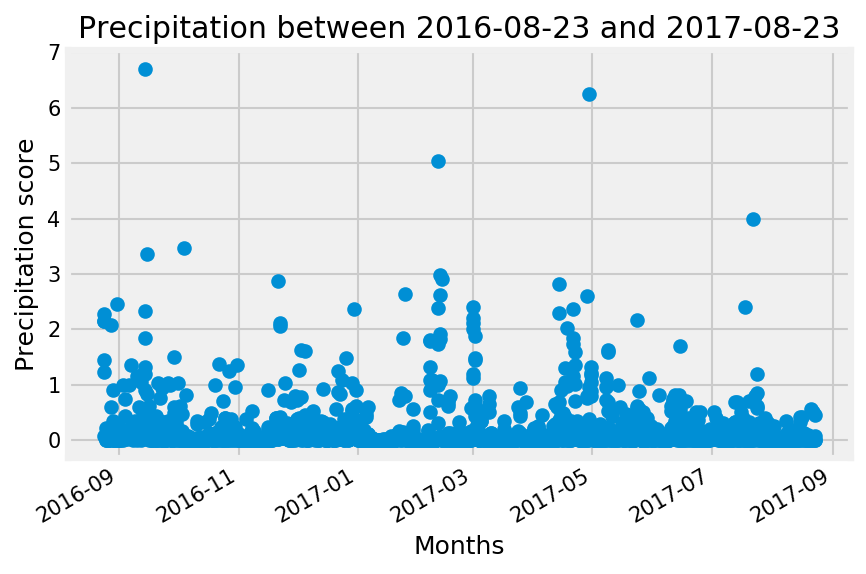

In [21]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(dpi=150)
ax.plot(df['date_fmt'], df['precipitation'], 'o')
ax = plt.title('Precipitation between 2016-08-23 and 2017-08-23')
ax = plt.xlabel('Months')
ax = plt.ylabel('Precipitation score')
fig.autofmt_xdate()

![precipitation](Images/precipitation.png)

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,record,precipitation,temp_f
count,2223.000000,2015.000000,2223.000000
mean,10159.397211,0.176462,74.578947
std,5604.268703,0.460288,4.612232
min,2365.000000,0.000000,58.000000
25%,5287.500000,0.000000,71.000000
50%,8931.000000,0.020000,75.000000
75%,14751.500000,0.130000,78.000000
max,19550.000000,6.700000,87.000000


![describe](Images/describe.png)

In [24]:
# Design a query to show how many stations are available in this dataset?
station_query = session.execute('''select count(distinct(station)) from measurement;''')
print(f'The dataset contains records from {station_query.fetchall()[0][0]} stations')

The dataset contains records from 9 stations


In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.execute('''select station, count(station) as num_records 
                                    from measurement 
                                    group by station
                                    order by num_records desc;''').fetchall()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_dict = {}
station_dict['station_id'] = station_count[0][0]
station_dict['lowest_temp'] = min(df['temp_f'][df['station']==station_count[0][0]])
station_dict['highest_temp'] = max(df['temp_f'][df['station']==station_count[0][0]])
station_dict['average_temp'] = df['temp_f'][df['station']==station_count[0][0]].mean()
station_dict

{'station_id': 'USC00519281',
 'lowest_temp': 59.0,
 'highest_temp': 83.0,
 'average_temp': 73.0968660968661}

In [27]:
# Choose the station with the highest number of temperature observations.

station_tobs = session.execute('''select station, count(tobs) as num_tobs 
                                    from measurement 
                                    group by station
                                    order by num_tobs desc;''').fetchall()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_df = df[df['station']==station_tobs[0][0]]
active_df.head()

,record,station,date,precipitation,temp_f,date_fmt
1524,14609,USC00519281,2016-08-24,2.15,77.0,2016-08-24
1525,14610,USC00519281,2016-08-25,0.06,80.0,2016-08-25
1526,14611,USC00519281,2016-08-26,0.01,80.0,2016-08-26
1527,14612,USC00519281,2016-08-27,0.12,75.0,2016-08-27
1528,14613,USC00519281,2016-08-28,0.60,73.0,2016-08-28


Text(0.5, 0, 'Temperature, F')

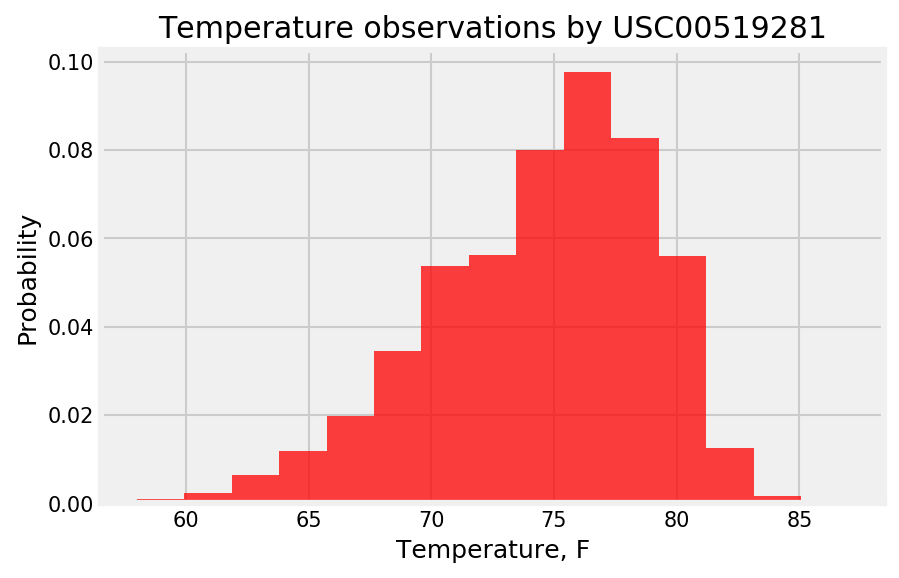

In [28]:
plt.figure(dpi = 150)
n, bins, patches = plt.hist(df['temp_f'], 15, density=True, facecolor='r', alpha=0.75)
plt.title(f'Temperature observations by {station_tobs[0][0]}')
plt.ylabel('Probability')
plt.xlabel('Temperature, F')

![precipitation](Images/station-histogram.png)

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [74]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2016-11-20'
trip_end = '2016-11-30'
tmin, tavg, tmax = calc_temps(trip_start, trip_end)[0]
print(tmin, tavg, tmax)

67.0 74.32352941176471 80.0


Text(0.5, 1.0, 'Average temperature')

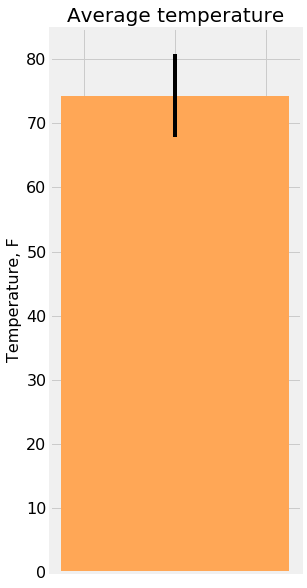

In [75]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize = (4,10))
ax.bar(1, tavg, yerr = (tmax-tmin)/2, width = 0.5, color = 'xkcd:pale orange')
ax.set_xticklabels([])
ax.set_ylabel('Temperature, F', fontsize = 16)
ax.tick_params(labelsize = 16)
ax.set_title('Average temperature', fontsize = 20)

In [88]:
trip_start_dt = dt.datetime.strptime(trip_start, '%Y-%m-%d')
trip_end_dt = dt.datetime.strptime(trip_start, '%Y-%m-%d')

df_trip = df[df["date_fmt"].between(trip_start_dt, df["date_fmt"], inclusive = True)]
df_trip.head()

,record,station,date,precipitation,temp_f,date_fmt
1612,14697,USC00519281,2016-11-20,0.39,75.0,2016-11-20
1960,19288,USC00516128,2016-11-20,NaN,74.0,2016-11-20
448,5180,USC00513117,2016-11-20,0.11,75.0,2016-11-20
88,2453,USC00519397,2016-11-20,0.05,76.0,2016-11-20
1274,11938,USC00519523,2016-11-20,0.40,80.0,2016-11-20


In [108]:
rain_df = pd.DataFrame(df_trip.groupby(by = ['station'])['precipitation'].sum())

query_stations = session.execute(f'select * from station;').fetchall()
stations_df = pd.DataFrame(query_stations, columns = ['num', 'station', 'name', 'lon', 'lat', 'elevation'])
# # stations_df.head()
rain_sorted = rain_df.sort_values(by = ['precipitation'], ascending = False)
rain_df = rain_sorted.merge(stations_df, on = ['station'])
rain_df.drop(columns = ['num'])

,station,precipitation,name,lon,lat,elevation
0,USC00516128,94.91,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,53.72,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,40.05,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,30.82,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,25.24,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,13.04,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,3.74,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


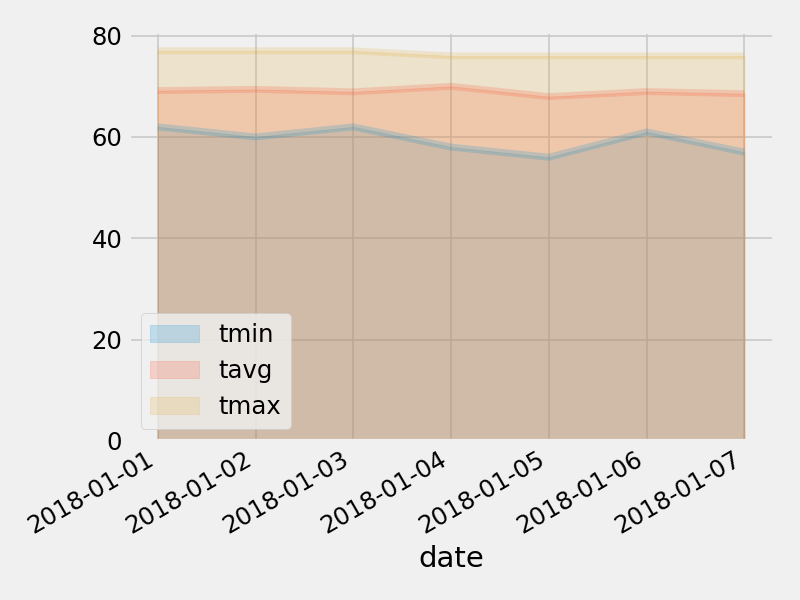

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
